Missing values in each column:
DateTime       0
Temperature    0
Humidity       0
pH             0
dtype: int64

Correlation Matrix:
             Temperature  Humidity  pH
Temperature     1.000000 -0.745447 NaN
Humidity       -0.745447  1.000000 NaN
pH                   NaN       NaN NaN


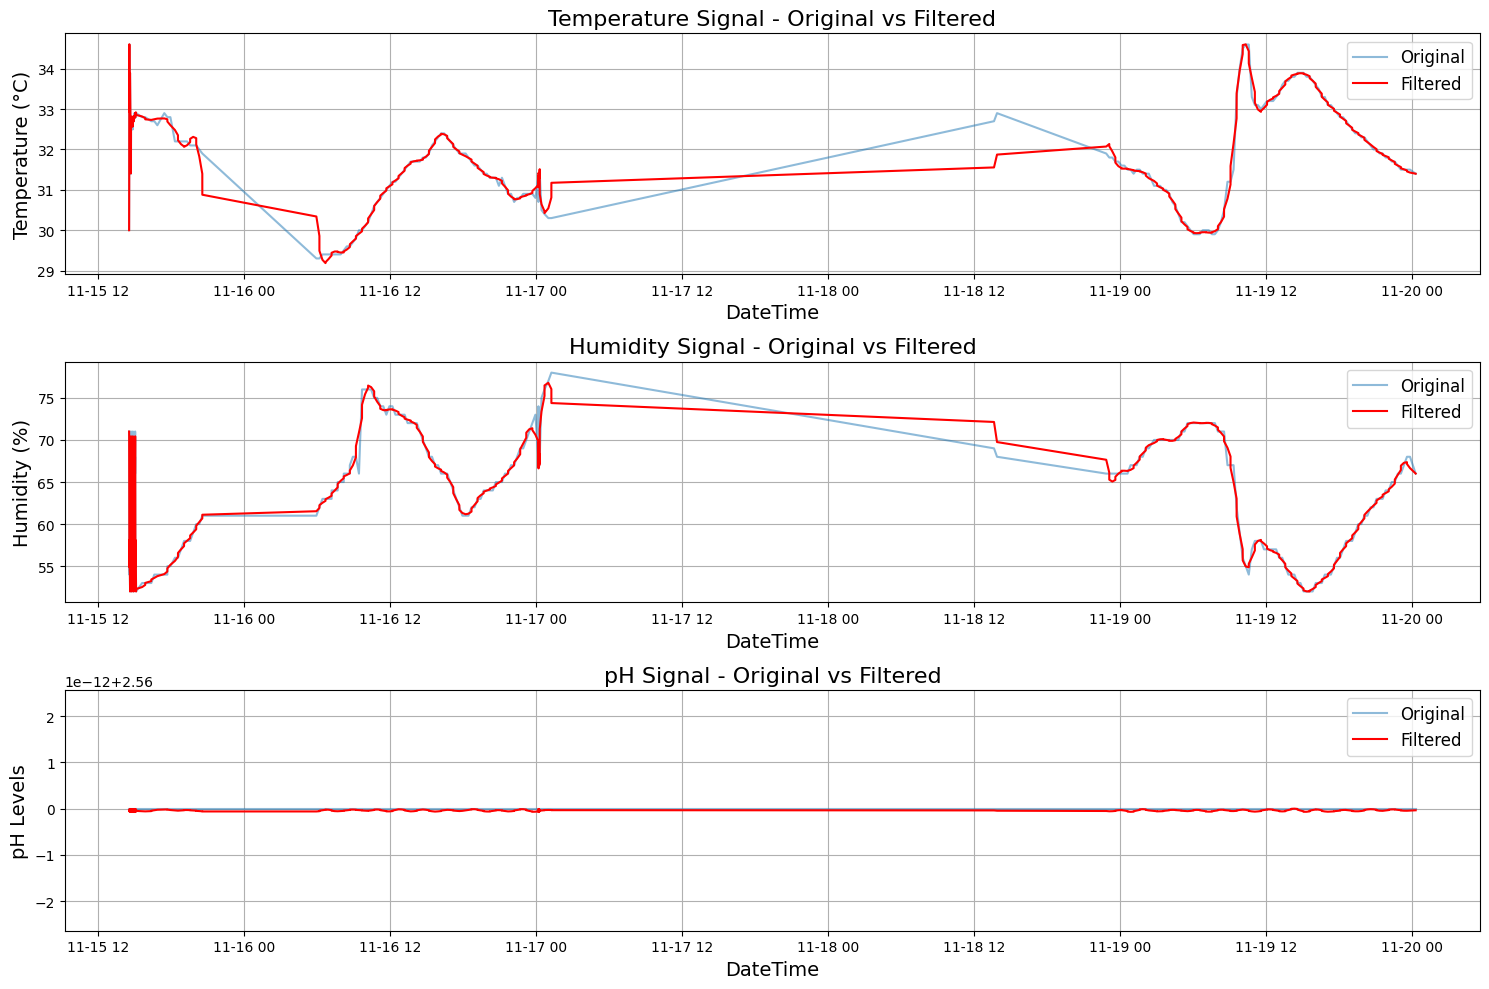

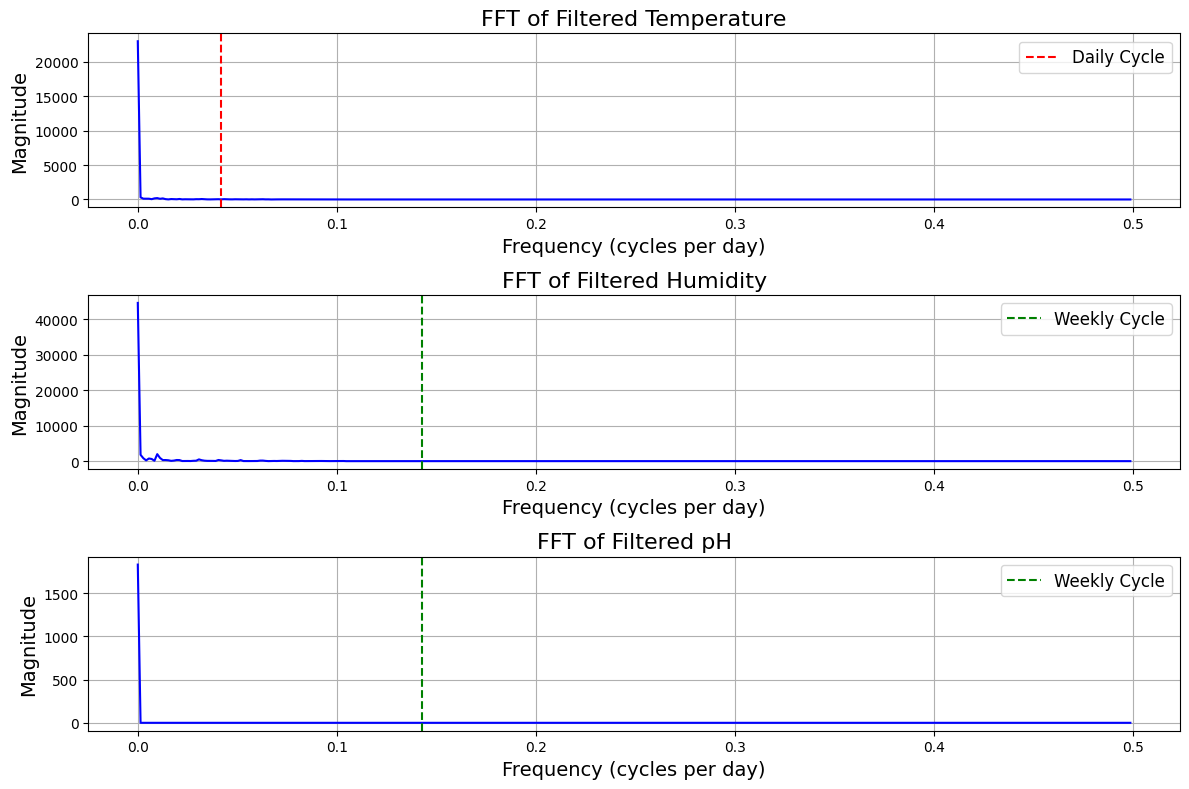

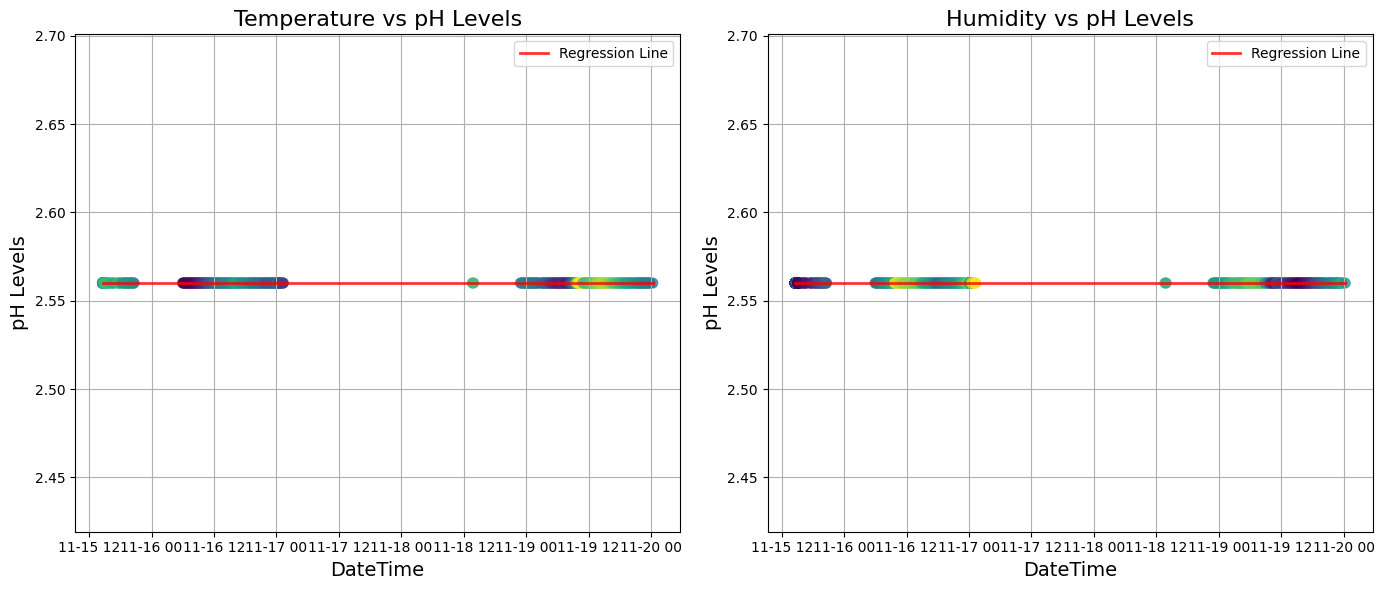

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft
from sklearn.linear_model import LinearRegression
import os

def load_and_preprocess_data(file_path, sheet_name):
    try:
        # Load data with error handling
        data = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Check for missing values
        print("Missing values in each column:")
        print(data.isnull().sum())
        
        # Strip whitespace from column names
        data.columns = data.columns.str.strip()
        
        # Validate required columns
        required_columns = ['DateTime', 'Temperature', 'Humidity', 'pH']
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Convert columns to numeric, handling missing values
        numeric_columns = ['Temperature', 'Humidity', 'pH']
        for col in numeric_columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        
        # Fill missing values with column means
        data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
        
        # Convert DateTime with robust parsing
        data['DateTime'] = pd.to_datetime(data['DateTime'], dayfirst=True, errors='coerce')
        
        # Check for any remaining invalid DateTimes
        if data['DateTime'].isnull().any():
            print("Warning: Some DateTimes could not be converted.")
        
        # Set DateTime as index
        data.set_index('DateTime', inplace=True)
        
        return data
    
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except ValueError as e:
        print(f"Data validation error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error loading data: {e}")
        return None

def create_butterworth_filter(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_lowpass_filter(data, cutoff, fs, order=5):
    b, a = create_butterworth_filter(cutoff, fs, order)
    return filtfilt(b, a, data)

def plot_signals_and_fft(data, filtered_signals, signal_names):
    # Plot original and filtered signals
    plt.figure(figsize=(15, 10))
    for i, (signal_data, filtered_data, name, ylabel) in enumerate(zip(
            [data.get(col) for col in signal_names],
            filtered_signals,
            [f'{name} Signal - Original vs Filtered' for name in signal_names],
            ['Temperature (°C)', 'Humidity (%)', 'pH Levels'])):

        if signal_data is not None and filtered_data is not None:
            plt.subplot(3, 1, i + 1)
            plt.plot(data.index, signal_data, label='Original', alpha=0.5)
            plt.plot(data.index, filtered_data, label='Filtered', color='red')
            plt.title(name, fontsize=16)
            plt.xlabel('DateTime', fontsize=14)
            plt.ylabel(ylabel, fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot FFT results
    n = len(data)
    fs = 1  # samples per day
    frequencies = np.fft.fftfreq(n, d=1/fs)
    
    plt.figure(figsize=(12, 8))
    for i, (fft_data, name) in enumerate(zip(
            [fft(signal) for signal in filtered_signals],
            [f'FFT of Filtered {name}' for name in signal_names])):

        if fft_data is not None:
            plt.subplot(3, 1, i + 1)
            plt.plot(frequencies[:n // 2], np.abs(fft_data)[:n // 2], color='blue')
            plt.title(name, fontsize=16)
            plt.xlabel('Frequency (cycles per day)', fontsize=14)
            plt.ylabel('Magnitude', fontsize=14)
            plt.axvline(x=0.0417 if i == 0 else 0.1429, color='r' if i == 0 else 'g', linestyle='--',
                       label='Daily Cycle' if i == 0 else 'Weekly Cycle')
            plt.legend(fontsize=12)
            plt.grid(True)

    plt.tight_layout()
    plt.show()

def create_scatter_plots(data):
    fig_scatter = plt.figure(figsize=(14, 6))

    # Temperature vs pH
    ax1 = fig_scatter.add_subplot(121)
    if all(col in data.columns for col in ['Temperature', 'pH']):
        ax1.scatter(data.index, data['pH'], c=data['Temperature'], cmap='viridis', s=50, alpha=0.7)
        ax1.set_title('Temperature vs pH Levels', fontsize=16)
        ax1.set_xlabel('DateTime', fontsize=14)
        ax1.set_ylabel('pH Levels', fontsize=14)
        ax1.grid(True)
        
        X_temp_ph = np.array((data.index - data.index[0]).total_seconds()).reshape(-1, 1)
        y_temp_ph = data['pH']
        
        model_temp_ph = LinearRegression()
        model_temp_ph.fit(X_temp_ph, y_temp_ph)
        predicted_ph_temp = model_temp_ph.predict(X_temp_ph)
        
        ax1.plot(data.index[:len(predicted_ph_temp)], predicted_ph_temp,
                 color='red', linewidth=2, alpha=0.8, label='Regression Line')
        ax1.legend()

    # Humidity vs pH
    ax2 = fig_scatter.add_subplot(122)
    if all(col in data.columns for col in ['Humidity', 'pH']):
        ax2.scatter(data.index, data['pH'], c=data['Humidity'], cmap='viridis', s=50, alpha=0.7)
        ax2.set_title('Humidity vs pH Levels', fontsize=16)
        ax2.set_xlabel('DateTime', fontsize=14)
        ax2.set_ylabel('pH Levels', fontsize=14)
        ax2.grid(True)
        
        X_humid_ph = np.array((data.index - data.index[0]).total_seconds()).reshape(-1, 1)
        y_humid_ph = data['pH']
        
        model_humid_ph = LinearRegression()
        model_humid_ph.fit(X_humid_ph, y_humid_ph)
        predicted_ph_humid = model_humid_ph.predict(X_humid_ph)
        
        ax2.plot(data.index[:len(predicted_ph_humid)], predicted_ph_humid,
                 color='red', linewidth=2, alpha=0.8, label='Regression Line')
        ax2.legend()

    fig_scatter.tight_layout()
    plt.show()

def main():
    # File path - consider using a relative or configurable path
    file_path = r"Copy of IoT Project (1).xlsx"
    sheet_name = "Project_IoT"
    
    # Load and preprocess data
    data = load_and_preprocess_data(file_path, sheet_name)
    
    if data is None:
        print("Data loading failed. Exiting analysis.")
        return
    
    # Parameters
    fs = 1  # sampling frequency (1 sample per day)
    cutoff_frequency = 0.1
    signal_names = ['Temperature', 'Humidity', 'pH']
    
    # Apply filtering
    filtered_signals = [
        apply_lowpass_filter(data[col].to_numpy(), cutoff_frequency, fs) 
        for col in signal_names if col in data.columns
    ]
    
    # Calculate and print correlation matrix
    correlation_matrix = data[signal_names].corr()
    print("\nCorrelation Matrix:")
    print(correlation_matrix)
    
    # Plot signals and their FFT
    plot_signals_and_fft(data, filtered_signals, signal_names)
    
    # Create scatter plots
    create_scatter_plots(data)

if __name__ == "__main__":
    main()

In [2]:
!pip install openpyxl